# TensorFlow - C11.E08
---

## Data Exploration

In [1]:
# load dataset
import numpy as np
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data ()

x_train.shape, y_train.shape, x_test.shape, y_test.shape

Using TensorFlow backend.


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

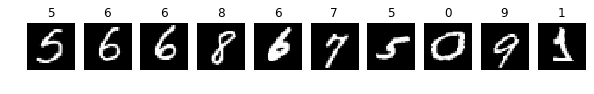

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

n = 10
idx_rnd = np.random.randint (0, x_train.shape[0], n)

fig, axs = plt.subplots (1, n)

for i in range(n):
    axs[i].imshow (x_train[idx_rnd[i]], cmap = 'gray')
    axs[i].set_title (y_train[idx_rnd[i]])
    axs[i].axis ('off')

fig.set_size_inches (10, 10)
plt.show ()

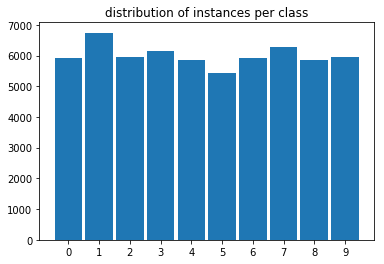

In [3]:
fig, axs = plt.subplots (1, 1)
axs.hist (y_train, range=(0,y_train.max()+1), align = 'left', rwidth = 0.9)
axs.set_xticks (range(y_train.max()+1));
axs.set_title ('distribution of instances per class')
plt.show ()

In [4]:
x_train.min (), x_train.max ()

(0, 255)

## Data Preprocessing
preprocessing steps that are common for all tasks

In [5]:
# min-max-scaling
x_train = x_train.astype ('f4') / np.max (x_train)
x_test = x_test.astype ('f4') / np.max (x_train)
(x_train.min (), x_train.max ()), (y_train.min (), y_train.max ())

((0.0, 1.0), (0, 9))

In [6]:
# take out all images from [0, 4]
# [i] [5, 9] is used for transfer learning later on
tmp_list_x_train_04 = []
tmp_list_y_train_04 = []
tmp_list_x_train_59 = []
tmp_list_y_train_59 = []
for i in range (0, 10):
    idx_i = np.where (y_train == i)[0]
    if (i < 5):
        tmp_list_x_train_04.append (x_train[idx_i])
        tmp_list_y_train_04.append (len (idx_i) * [i])
    else:
        tmp_list_x_train_59.append (x_train[idx_i])
        tmp_list_y_train_59.append (len (idx_i) * [i])

x_train_04 = np.vstack (tmp_list_x_train_04)
y_train_04 = np.hstack (tmp_list_y_train_04)
x_train_59 = np.vstack (tmp_list_x_train_59)
y_train_59 = np.hstack (tmp_list_y_train_59)

del tmp_list_x_train_04, tmp_list_y_train_04, tmp_list_x_train_59, tmp_list_y_train_59

(x_train_04.shape, y_train_04.shape), (x_train_59.shape, y_train_59.shape)

(((30596, 28, 28), (30596,)), ((29404, 28, 28), (29404,)))

In [7]:
# do the same for test dataset
tmp_list_x_test_04 = []
tmp_list_y_test_04 = []
tmp_list_x_test_59 = []
tmp_list_y_test_59 = []
for i in range (0, 10):
    idx_i = np.where (y_test == i)[0]
    if (i < 5):
        tmp_list_x_test_04.append (x_test[idx_i])
        tmp_list_y_test_04.append (len (idx_i) * [i])
    else:
        tmp_list_x_test_59.append (x_test[idx_i])
        tmp_list_y_test_59.append (len (idx_i) * [i])

x_test_04 = np.vstack (tmp_list_x_test_04)
y_test_04 = np.hstack (tmp_list_y_test_04)
x_test_59 = np.vstack (tmp_list_x_test_59)
y_test_59 = np.hstack (tmp_list_y_test_59)

del tmp_list_x_test_04, tmp_list_y_test_04, tmp_list_x_test_59, tmp_list_y_test_59

(x_test_04.shape, y_test_04.shape), (x_test_59.shape, y_test_59.shape)

(((5139, 28, 28), (5139,)), ((4861, 28, 28), (4861,)))

## a. + b. DNN with
- 5 hidden layers of 100 units each
- He initialization
- ELU activation
- \
- Adam optimization
- early stopping
- checkpoint saver
- final model saver
- Softmax output with 5 units

### Data Preprocessing

In [8]:
# split into training and validation set
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split (
    x_train_04, y_train_04, test_size = 0.25, shuffle = True, random_state = 12
)

# flatten sets
X_train = X_train.reshape (X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_val = X_val.reshape (X_val.shape[0], X_val.shape[1]*X_val.shape[2])
X_test = x_test_04.reshape (x_test_04.shape[0], x_test_04.shape[1]*x_test_04.shape[2])
y_test = y_test_04

print ('train set:', X_train.shape, y_train.shape)
print ('val set:', X_val.shape, y_val.shape)
print ('test set:', X_test.shape, y_test.shape)

train set: (22947, 784) (22947,)
val set: (7649, 784) (7649,)
test set: (5139, 784) (5139,)


In [9]:
y_train.min (), y_train.max (), y_val.min (), y_val.max ()
np.histogram (y_train, bins=[0] + [x+.5 for x in range(5)])

(array([4426, 5083, 4437, 4594, 4407], dtype=int64),
 array([0. , 0.5, 1.5, 2.5, 3.5, 4.5]))

### Implementation

Kernel initialization:

He initialization (also known as MSRA initialization) for ReLU (as well as ELU) with normal distribution:

$\sigma = \sqrt{2} \sqrt{\frac{2}{fan\_in + fan\_out}} = \sqrt{\frac{2}{\frac{fan\_in+fan\_out}{2}}}$

Function <pre>tf.contrib.layers.variance_scaling_initializery</pre> with args:
- factor = 2.0
- mode = 'FAN_AVG' (= $\frac{fan\_in + fan\_out}{2}$)

In [10]:
import numpy as np
import tensorflow as tf
from functools import partial

class MlpMnist ():
    
    # construction phase
    def __init__ (self, name = 'MlpMnist', lr = 0.001, beta1 = 0.9, beta2 = 0.999):
        
        n_inputs = 28*28
        n_layers = 5
        n_units = 100
        n_outputs = 5
        
        tf.reset_default_graph ()
        
        self.__X = tf.placeholder (
            shape = (None, n_inputs),
            dtype = tf.float32,
            name = 'X'
        )
        self.__y = tf.placeholder (
            shape = (None),
            dtype = tf.int32,
            name = 'y'
        )


        he_init = tf.contrib.layers.variance_scaling_initializer (
            factor = 2.0,
            mode = 'FAN_AVG',
            uniform = False
        )

        fc_layer = partial (
            tf.layers.dense,
            units = n_units,
            kernel_initializer = he_init,
            activation = tf.nn.elu
        )
        with tf.name_scope ('dnn'):
            fc1 = fc_layer (
                inputs = self.__X,
                name = 'fc1'
            )
            fc2 = fc_layer (
                inputs = fc1,
                name = 'fc2'
            )
            fc3 = fc_layer (
                inputs = fc2,
                name = 'fc3'
            )
            fc4 = fc_layer (
                inputs = fc3,
                name = 'fc4'
            )
            fc5 = fc_layer (
                inputs = fc4,
                name = 'fc5'
            )
            self.__logits = tf.layers.dense (
                inputs = fc5,
                units = n_outputs,
                activation = None,
                name = 'outputs'
            )


        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits (
            labels = self.__y,
            logits = self.__logits
        )
        loss = tf.reduce_mean (xentropy, name = 'loss')
        
        
        self.__optimizer = tf.train.AdamOptimizer (learning_rate = lr, beta1 = beta1, beta2 = beta2)
        self.__training_op = self.__optimizer.minimize (loss)


        with tf.name_scope ('eval'):
            correct = tf.nn.in_top_k (self.__logits, self.__y, 1)
            self.__accuracy = tf.reduce_mean (tf.cast (correct, tf.float32))


        self.__init = tf.global_variables_initializer ()
        self.__saver = tf.train.Saver ()
        
       
        self._max_acc_val_ = 0
        self._save_path_best_ = None
        self.name = name
    
    
    # execution phase
    def fit (self, X_train, y_train, X_val, y_val):
        
        N_EPOCHS = 10
        BATCH_SIZE = 40
        n_batches = int (np.ceil (X_train.shape[0] / BATCH_SIZE))

        # early stopping
        early_stop = False
        patience = 0
        epoch_best = 0

        with tf.Session () as sess:
            self.__init.run ()

            for epoch in range (N_EPOCHS):

                for it in range (n_batches):

                    feed_dict = {
                        self.__X : X_train[it*BATCH_SIZE:(it+1)*BATCH_SIZE],
                        self.__y : y_train[it*BATCH_SIZE:(it+1)*BATCH_SIZE]
                    }

                    sess.run (self.__training_op, feed_dict = feed_dict)

                
                acc_train = self.__accuracy.eval (feed_dict = feed_dict)
                acc_val = self.__accuracy.eval (feed_dict = {self.__X : X_val, self.__y : y_val})
                print (epoch, ', train acc:', acc_train, ', val acc:', acc_val)
                
                # early stopping
                if (acc_val > self._max_acc_val_):
                    self._max_acc_val_ = acc_val
                    self._save_path_best_ = self.__saver.save (sess, './tf_saves/{}_{}'.format (self.name, '_best_acc_val.ckpt'))
                    epoch_best = epoch
                    print ('val acc improved, model saved to', self._save_path_best_)
                else:
                    if (patience + epoch > epoch_best):
                        print ('early stopping after epoch {}'.format (epoch, it))
                        early_stop = True
            
                if (early_stop):
                    break
    
    
    # predicition
    def score (self, X_test, y_test):

        if (self._save_path_best_ is None):
            return -1

        acc_test = -1
        with tf.Session () as sess:
            self.__saver.restore (sess, self._save_path_best_)

            #Z = logits.eval (feed_dict = {self.__X : X_test})
            #y_pred_distr = tf.nn.softmax (Z).eval ()
            #y_pred = np.argmax (y_pred_distr, axis = 1)

            acc_test = self.__accuracy.eval (feed_dict = {self.__X : X_test, self.__y : y_test})

        return acc_test

In [11]:
mlp = MlpMnist (name = 'MlpMnist')
mlp.fit (X_train, y_train, X_val, y_val)

0 , train acc: 1.0 , val acc: 0.9743757
val acc improved, model saved to ./tf_saves/MlpMnist__best_acc_val.ckpt
1 , train acc: 0.962963 , val acc: 0.9731991
early stopping after epoch 1


In [12]:
# max acc val
print ('score validation set:', mlp._max_acc_val_)
# predictions
print ('score test set:', mlp.score (X_test, y_test))

score validation set: 0.9743757
INFO:tensorflow:Restoring parameters from ./tf_saves/MlpMnist__best_acc_val.ckpt
score test set: 0.90153724


### c. Grid Search w/ Cross Validation

Exhaustive grid search with k-fold cross validation is applied to find the best hyperparameters for the used MLP architecture.

Hereby, the original training set is split into k subsets, which are then used to train a MLP with specific hyperparameters by
- iterating through every subset as the current validation set
- train the MLP on the remaining subsets
- save validation and test accuracy of best run

Since the training time is short, grid search can be used here. If training time is too long, it is advised to take randomized search.

In [13]:
x_train_04.shape, y_train_04.shape

((30596, 28, 28), (30596,))

In [14]:
# make stratified folds of the dataset to preserve a balanced distribution of samples over classes
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold (n_splits = 4, shuffle = False, random_state = 42)
skf

StratifiedKFold(n_splits=4, random_state=42, shuffle=False)

In [15]:
# grid search parameter sets
import itertools as it

# parameter grid
param_grid = {
    'lr' : [0.1, 0.01, 0.001, 0.0001],
    'beta1' : [0.9, 0.7, 0.5],
    'beta2' : [0.999, 0.799, 0.599]
}

# make every possible combination of parameter values
param_combinations = list (it.product (*param_grid.values ()))
len (param_combinations)

36

In [16]:
# also see function StratifiedShuffleSplit
from collections import defaultdict

# shuffle dataset first
x_train_04, _, y_train_04, _ = train_test_split (
    x_train_04, y_train_04, test_size = 0.0, train_size = None, shuffle = True, random_state = 42
)


cv_results = defaultdict (list)

i = 0
for pc in param_combinations:
    
    name = 'mlpkfold_{}'.format (i)
    
    print ('[i]', name, pc)
    
    cv_results[name].append (pc)
    
    cur_mlp = MlpMnist (
        name = name,
        lr = pc[0],
        beta1 = pc[1],
        beta2 = pc[2]
    )
    
    acc_val_list = []
    acc_test_list = []
    for train_idx, val_idx in skf.split (x_train_04, y_train_04):
        X_train, X_val = x_train_04[train_idx], x_train_04[val_idx]
        y_train, y_val = y_train_04[train_idx], y_train_04[val_idx]

        X_train = X_train.reshape (X_train.shape[0], X_train.shape[1]*X_train.shape[2])
        X_val = X_val.reshape (X_val.shape[0], X_val.shape[1]*X_val.shape[2])

        cur_mlp.fit (X_train, y_train, X_val, y_val)
        acc_val_list.append (cur_mlp._max_acc_val_)
        acc_test_list.append (cur_mlp.score (X_test, y_test))
    
    cv_results[name].append (acc_val_list)
    cv_results[name].append (acc_test_list)
    
    i += 1

[i] mlpkfold_0 (0.1, 0.9, 0.999)
0 , train acc: 0.88 , val acc: 0.8409358
val acc improved, model saved to ./tf_saves/mlpkfold_0__best_acc_val.ckpt
1 , train acc: 0.92 , val acc: 0.8618481
val acc improved, model saved to ./tf_saves/mlpkfold_0__best_acc_val.ckpt
2 , train acc: 0.92 , val acc: 0.8743955
val acc improved, model saved to ./tf_saves/mlpkfold_0__best_acc_val.ckpt
3 , train acc: 0.72 , val acc: 0.6447523
early stopping after epoch 3
INFO:tensorflow:Restoring parameters from ./tf_saves/mlpkfold_0__best_acc_val.ckpt
0 , train acc: 0.92 , val acc: 0.9436675
val acc improved, model saved to ./tf_saves/mlpkfold_0__best_acc_val.ckpt
1 , train acc: 0.92 , val acc: 0.9507254
val acc improved, model saved to ./tf_saves/mlpkfold_0__best_acc_val.ckpt
2 , train acc: 0.92 , val acc: 0.94745785
early stopping after epoch 2
INFO:tensorflow:Restoring parameters from ./tf_saves/mlpkfold_0__best_acc_val.ckpt
0 , train acc: 0.17857143 , val acc: 0.20044456
1 , train acc: 0.17857143 , val acc: 

In [17]:
# make a clean version of cv_results as DataFrame
import pandas as pd

df_data = []
for cv_mlp in cv_results:
    data = [cv_mlp] + [param for param in cv_results[cv_mlp][0]] +\
    [np.mean (cv_results[cv_mlp][1])] + [np.std (cv_results[cv_mlp][1])] +\
    [np.mean (cv_results[cv_mlp][2])] + [np.std (cv_results[cv_mlp][2])]
    df_data.append (data)


col_names = ['estimator_name'] + [x for x in param_grid.keys ()] + ['acc_val_mean', 'acc_val_std', 'acc_test_mean', 'acc_test_std']
cv_results_pd = pd.DataFrame (df_data, columns = col_names)

In [18]:
cv_results_pd

,estimator_name,lr,beta1,beta2,acc_val_mean,acc_val_std,acc_test_mean,acc_test_std
0,mlpkfold_0,0.1000,0.9,0.999,0.931643,0.033052,0.499076,0.146023
1,mlpkfold_1,0.1000,0.9,0.799,0.220363,0.000000,0.220860,0.000000
2,mlpkfold_2,0.1000,0.9,0.599,0.000000,0.000000,-1.000000,0.000000
3,mlpkfold_3,0.1000,0.7,0.999,0.909162,0.000000,0.725822,0.000000
4,mlpkfold_4,0.1000,0.7,0.799,0.220363,0.000000,0.072193,0.000000
5,mlpkfold_5,0.1000,0.7,0.599,0.220363,0.000000,0.220860,0.000000
6,mlpkfold_6,0.1000,0.5,0.999,0.780192,0.323217,0.347198,0.087546
7,mlpkfold_7,0.1000,0.5,0.799,0.200405,0.000039,0.197315,0.000778
8,mlpkfold_8,0.1000,0.5,0.599,0.200405,0.000039,0.278264,0.017708
9,mlpkfold_9,0.0100,0.9,0.999,0.979738,0.003134,0.973536,0.007200


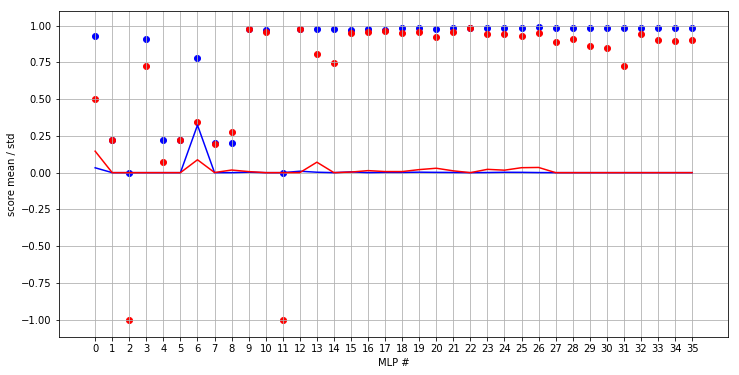

In [19]:
fig, axs = plt.subplots (1, 1)

axs.scatter (
    x = cv_results_pd.index.values,
    y = cv_results_pd['acc_val_mean'].values,
    color = 'b'
)
axs.plot (
    cv_results_pd['acc_val_std'].values,
    color = 'b'
)

axs.scatter (
    x = cv_results_pd.index.values,
    y = cv_results_pd['acc_test_mean'].values,
    color = 'r'
)
axs.plot (
    cv_results_pd['acc_test_std'].values,
    color = 'r'
)

axs.set_xticks (cv_results_pd.index.values)
axs.grid (True)

axs.set_xlabel ('MLP #')
axs.set_ylabel ('score mean / std')

fig.set_size_inches (12, 6)

plt.show ()

best estimator:
- blue and red dot close together
- blue and red mean score high
- blue and red std low

--> MLP #9, #12, #17, #22

whereby MLP #9 and #22 are visually outstanding



In [23]:
cv_results_pd.iloc[[9, 12, 17, 22]]

,estimator_name,lr,beta1,beta2,acc_val_mean,acc_val_std,acc_test_mean,acc_test_std
9,mlpkfold_9,0.010,0.9,0.999,0.979738,0.003134,0.973536,0.007200
12,mlpkfold_12,0.010,0.7,0.999,0.973794,0.009621,0.975773,0.000169
17,mlpkfold_17,0.010,0.5,0.599,0.973206,0.002037,0.964779,0.007415
22,mlpkfold_22,0.001,0.7,0.799,0.984839,0.000000,0.981125,0.000000


#### retrain best estimator

In [24]:
# retrain best estimator
print ('train set:', X_train.shape, y_train.shape)
print ('val set:', X_val.shape, y_val.shape)
print ('test set:', X_test.shape, y_test.shape)

train set: (22950, 784) (22950,)
val set: (7646, 784) (7646,)
test set: (5139, 784) (5139,)


In [25]:
# hyperparameters of MLP #22
mlp_best = MlpMnist (
    name = 'MlpBest',
    lr = 0.001,
    beta1 = 0.7,
    beta2 = 0.799
)

mlp_best.fit (X_train, y_train, X_val, y_val)

0 , train acc: 1.0 , val acc: 0.98025113
val acc improved, model saved to ./tf_saves/MlpBest__best_acc_val.ckpt
1 , train acc: 1.0 , val acc: 0.98090506
val acc improved, model saved to ./tf_saves/MlpBest__best_acc_val.ckpt
2 , train acc: 1.0 , val acc: 0.9880983
val acc improved, model saved to ./tf_saves/MlpBest__best_acc_val.ckpt
3 , train acc: 1.0 , val acc: 0.9862673
early stopping after epoch 3


In [26]:
mlp_best.score (X_test, y_test)

INFO:tensorflow:Restoring parameters from ./tf_saves/MlpBest__best_acc_val.ckpt


0.9698385

## TODO

### k-fold cross validation with sklearn's GridSearchCV
Does not work currently due to:

'Cannot clone object '<__main__.MlpMnist object at 0x0000015B4E127978>' (type <class '__main__.MlpMnist'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' methods.'

In [296]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'lr' : [0.1, 0.01, 0.001, 0.0001],
    'beta1' : [0.9],
    'beta2' : [0.999]
}

mlpkfold = MlpMnist (name = 'mlpkfold')

gscv = GridSearchCV (
    estimator = mlpkfold,
    param_grid = param_grid,
    cv = skf,
    n_jobs = 1,
    refit = False
)
gscv

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=False),
       error_score='raise-deprecating',
       estimator=<__main__.MlpMnist object at 0x0000015B5370D908>,
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'lr': [0.1, 0.01, 0.001, 0.0001], 'beta1': [0.9], 'beta2': [0.999]},
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring=None, verbose=0)

In [297]:
# shuffle dataset first
#x_train_04, _, y_train_04, _ = train_test_split (
#    x_train_04, y_train_04, test_size = 0.0, train_size = None, shuffle = True, random_state = 42
#)

#gscv.fit (x_train_04, y_train_04)